In [68]:
import os
import json
import pandas as pd
import numpy as np
import re

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import requests
import re
import pandas as pd

import warnings
warnings.simplefilter('ignore')

init_notebook_mode(connected=True)


import seaborn as sns
%matplotlib inline

In [69]:
df_movie_list = []
for f in os.listdir('./movie_data/'):
    path =  os.path.join(os.getcwd(),'movie_data/',f)
    with open(path,'r', encoding = "utf-8",errors = 'ignore') as f:
        data = json.load(f)
    data_df = pd.DataFrame(data)
    df_movie_list.append(data_df)
movie_data_df = pd.concat(df_movie_list,ignore_index=True)

# EDA

In [71]:
movie_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1079 entries, 0 to 1078
Data columns (total 14 columns):
age_restriction    1079 non-null object
country            1079 non-null object
director           1079 non-null object
duration           1079 non-null object
genre              1079 non-null object
imdb_rating        1079 non-null object
imdb_rating_cnt    1079 non-null object
kp_rating          1079 non-null float64
kp_rating_cnt      1079 non-null object
movie_desc         1079 non-null object
movie_id           1079 non-null int64
name_eng           1079 non-null object
name_rus           1079 non-null object
release_year       1079 non-null object
dtypes: float64(1), int64(1), object(12)
memory usage: 118.1+ KB


In [72]:
movie_data_df.describe()

,kp_rating,movie_id
count,1079.000000,1.079000e+03
mean,7.022996,2.976260e+05
std,1.039705,3.297914e+05
min,1.030000,3.250000e+02
25%,6.613500,4.244000e+04
50%,7.170000,1.020490e+05
75%,7.699500,4.789470e+05
max,9.112000,1.202991e+06


In [73]:
movie_data_df.shape

(1079, 14)

In [74]:
movie_data_df['duration'] = pd.to_numeric(movie_data_df['duration'] , errors='coerce')
movie_data_df['imdb_rating'] = pd.to_numeric(movie_data_df['imdb_rating'] , errors='coerce')
movie_data_df['imdb_rating_cnt'] = pd.to_numeric(movie_data_df['imdb_rating_cnt'] , errors='coerce')
movie_data_df['kp_rating'] = pd.to_numeric(movie_data_df['kp_rating'] , errors='coerce')
movie_data_df['kp_rating_cnt'] = pd.to_numeric(movie_data_df['kp_rating_cnt'] , errors='coerce')
movie_data_df['country'] = movie_data_df['country'].fillna(np.nan)
movie_data_df['genre'] = movie_data_df['genre'].astype('str')
movie_data_df['director'] = movie_data_df['director'].astype('str')
movie_data_df['movie_desc'] = movie_data_df['movie_desc'].astype('str')
movie_data_df['name_eng'] = movie_data_df['name_eng'].astype('str')
movie_data_df['name_rus'] = movie_data_df['name_rus'].astype('str')
def find_age(age_str):
    prog = re.compile(r'\d+')
    matches = re.findall(prog,age_str)
    if matches != []:
        return matches[0]
    elif "любой" in age_str:
        return 0
    else:
        return np.nan
        
movie_data_df['age_restriction'] = movie_data_df['age_restriction'].apply(find_age)
#if data has  some other than numeric types we can escape errors by passing the errors coeff in the to_numeric method
movie_data_df['age_restriction'] = pd.to_numeric(movie_data_df['age_restriction'] , errors='coerce')
movie_data_df['country'] = movie_data_df.loc[:,'country'].apply(lambda x: 'не определено' if x == '' else x)
movie_data_df['genre'] = movie_data_df.loc[:,'genre'].apply(lambda x: 'не определено' if x == '' or x == 'NaN' else x)

In [75]:
usefule_col = [x for x in movie_data_df.columns if x != 'movie_desc']

In [76]:
movie_data_df = movie_data_df[usefule_col]

In [77]:
movie_data_df.head()

,age_restriction,country,director,duration,genre,imdb_rating,imdb_rating_cnt,kp_rating,kp_rating_cnt,movie_id,name_eng,name_rus,release_year
0,NaN,не определено,,95.0,не определено,7.1,241.0,7.837,2227.0,738837,Terre des ours,,2013
1,NaN,не определено,,247.0,не определено,6.7,117.0,7.220,1115.0,77279,,(-),1973
2,NaN,не определено,,7.0,не определено,5.0,16.0,4.496,97.0,578163,,,1939
3,NaN,не определено,,42.0,не определено,NaN,NaN,5.885,62.0,331772,,(),1964
4,16.0,не определено,,91.0,не определено,6.1,1469.0,6.979,20656.0,41531,,", -",1992


In [82]:
movie_data_df = movie_data_df[~movie_data_df['name_rus'].str.contains(r'^\(|\)|\.|\-', regex = True)]

# Зависит ли оценка фильма от количества оценок?

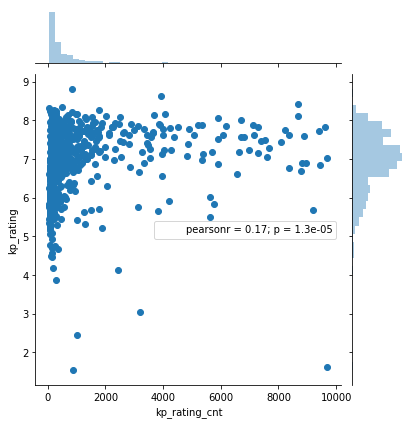

In [83]:
g = sns.jointplot(data = movie_data_df, y = 'kp_rating', x = 'kp_rating_cnt');

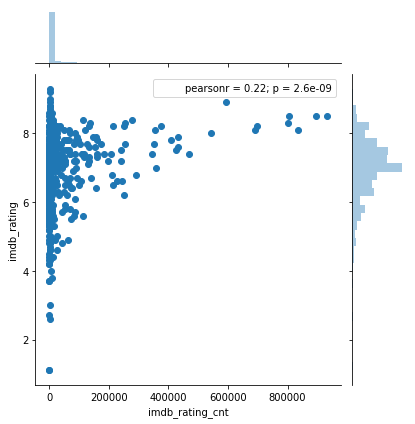

In [84]:
sns.jointplot(data = movie_data_df, y = 'imdb_rating', x = 'imdb_rating_cnt')

#### Построим зависимость оценки, количества               

In [85]:
import plotly.plotly as py
import plotly.graph_objs as go

In [86]:
movie_matrix = movie_data_df[['kp_rating', 'kp_rating_cnt']].copy()

In [87]:
movie_matrix['count'] = 1
movie_matrix['kp_rating_rounded'] = movie_matrix ['kp_rating'].round(1)
movie_matrix['kp_rating_count_rounded'] = movie_matrix ['kp_rating_cnt'].round(-2)
total = movie_matrix['count'].sum()

In [88]:
z_data = movie_matrix.pivot_table(index = 'kp_rating_rounded', columns = 'kp_rating_count_rounded',values = 'count', aggfunc = sum)
z_data = z_data.applymap(lambda x: float(x)/total)

In [89]:
data = [
    go.Surface(
        z = z_data.values, x = z_data.index.values, y = z_data.columns,
        contours=go.surface.Contours(
            z=go.surface.contours.Z(
              show=True,
              usecolormap=True,
              highlightcolor="#42f462",
              project=dict(z=True)
            )
        )
    )
]
layout = go.Layout(
    title='Зависимости оценки от количества и ее доли в общем количестве',
    autosize=False,
    scene=dict(camera=dict(eye=dict(x=1.87, y=0.88, z=-0.64)),xaxis = dict(title='Оценка'),yaxis = dict(title='Количество'),zaxis = dict(title='Доля')),
    width=700,
    height=700,
    margin=dict(
        l=65,
        r=50,
        b=65,
        t=90
    ),
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

# Самые популярные жанры и их характеристики

In [90]:
movie_data_df.head()

,age_restriction,country,director,duration,genre,imdb_rating,imdb_rating_cnt,kp_rating,kp_rating_cnt,movie_id,name_eng,name_rus,release_year
0,NaN,не определено,,95.0,не определено,7.1,241.0,7.837,2227.0,738837,Terre des ours,,2013
2,NaN,не определено,,7.0,не определено,5.0,16.0,4.496,97.0,578163,,,1939
5,12.0,не определено,,75.0,не определено,6.0,23.0,6.018,303.0,45543,,,1986
6,18.0,не определено,,133.0,не определено,8.3,13542.0,7.915,1144.0,57258,Huo zhe,,1994
9,16.0,не определено,,99.0,не определено,7.0,38.0,7.539,844.0,42019,,,1975


In [91]:
popular_genres = movie_data_df.groupby('genre')[['movie_id']].count().sort_values('movie_id', ascending = False).head(10).index.values.tolist()
popular_genres = [x for x in popular_genres if x!='не определено']

In [92]:
N = float(len(popular_genres))
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, N)]
data = [{
    'y': movie_data_df[movie_data_df.genre == popular_genres[i]].kp_rating, 
    'type':'box',
    'marker':{'color': c[i]},
    'name': popular_genres[i]
    } for i in range(len(popular_genres))]

layout = go.Layout(
    yaxis=dict(
        title='Оценка',
    ),
    title = "Характеристики самых популярных жанров"

)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

# Как распределялись жанры по годам?

In [93]:
movie_data_df['genre_top'] = movie_data_df['genre'].apply(lambda x: x if x in popular_genres else 'другое')

In [94]:
N = float(len(popular_genres) + 1)
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, N)]

In [30]:
items_list = []
N = int(N)
items_list.append(
    dict(
        args=['visible', [True] + [False]*N],
        label=u'все',
        method='restyle'
    )
)
for i in range(len(popular_genres)):
    items_list.append(
        dict(
            args=['visible', [False]*(i+1) + [True] + [False]*(N-1-i)],
            label= popular_genres[i],
            method='restyle'
        )
    )

In [41]:
data = []
total = movie_data_df.groupby('release_year').movie_id.nunique()
trace = go.Bar(
        x = total.index.values,
        y = total.values,
        name = u'Всего',
        marker = {'color': c[0]}
    )

data.append(trace)
for i in range(len(popular_genres)):
    genre = popular_genres[i]
    tmp_df = movie_data_df[movie_data_df.genre_top == genre].groupby('release_year').movie_id.nunique()
    trace = go.Bar(
        x = tmp_df.index.values,
        y = tmp_df.values,
        name = genre,
        marker = {'color': c[i+1]},
        visible = False
    )
    data.append(trace)

layout = go.Layout(
    xaxis = dict(title='Год'),
    title='Фильмы по жанрам',
    updatemenus=list([
        dict(
            x=-0.1,
            y=1,
            yanchor='top',
            buttons=items_list
        )
    ]),
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [33]:
movie_data_df['share'] = 1

In [34]:
movie_data_df_pivot = movie_data_df.pivot_table(index = 'release_year', values = 'share',
                     aggfunc = sum, columns = 'genre_top')

In [36]:
movie_data_df_pivot = movie_data_df_pivot.apply(lambda x: x/movie_data_df_pivot.sum(axis =1))

In [42]:
data = []
for genre in movie_data_df.genre_top.unique():
    trace = go.Bar(
        x = movie_data_df_pivot.index.values,
        y = movie_data_df_pivot[genre].values,
        name = genre
    )
    data.append(trace)

layout = go.Layout(
    barmode='stack',
    title = "Соотношение самых популярных жанров по годам",
    xaxis = dict(title = "Год"),
    yaxis = dict(title = "Доля")
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

# Менялись ли оценки фильмов в зависимости от года выпуска?

In [43]:
movie_data_df_rating = movie_data_df.groupby('release_year', as_index = False)[['kp_rating','imdb_rating']].mean()

In [46]:
kp = go.Scatter(
    x = movie_data_df_rating.release_year,
    y = movie_data_df_rating.kp_rating,
    mode = 'lines',
    name = u'КиноПоиск'
)
imdb = go.Scatter(
    x = movie_data_df_rating.release_year,
    y = movie_data_df_rating.imdb_rating,
    mode = 'lines',
    name = 'IMDb'
)

layout = go.Layout(
    title='Оценки фильмов',
    xaxis = dict(title = "Год"),
    yaxis = dict(title = "Оценка"),
)   
    
fig = go.Figure(data = [kp, imdb], layout = layout)
iplot(fig)

In [49]:
movie_data_df_age = movie_data_df[movie_data_df['age_restriction'] >= 0]

In [51]:
movie_data_df_age_pivot = movie_data_df_age.pivot_table(index = 'age_restriction', values = 'share',
                     aggfunc = sum, columns = 'genre_top')

In [53]:
movie_data_df_age_pivot = movie_data_df_age_pivot.apply(lambda x: x/movie_data_df_age_pivot.sum(axis=1))

In [54]:
movie_data_df_age_pivot

genre_top,боевик,документальный,драма,другое,комедия,мелодрама,мультфильм,триллер,фантастика,фэнтези
age_restriction,,,,,,,,,,
0.0,0.009346,0.009346,0.186916,0.542056,0.046729,0.046729,0.130841,NaN,0.009346,0.018692
6.0,NaN,NaN,0.157895,0.438596,0.070175,0.035088,0.245614,NaN,0.052632,NaN
12.0,0.039106,0.016760,0.268156,0.340782,0.089385,0.055866,0.044693,0.016760,0.078212,0.050279
13.0,NaN,NaN,0.142857,0.428571,0.142857,NaN,NaN,NaN,0.142857,0.142857
16.0,0.081967,0.016393,0.316940,0.333333,0.054645,0.027322,0.010929,0.081967,0.054645,0.021858
17.0,0.166667,0.166667,NaN,0.333333,NaN,NaN,NaN,0.166667,0.166667,NaN
18.0,0.044776,NaN,0.313433,0.283582,0.059701,0.029851,NaN,0.238806,NaN,0.029851


In [67]:
data = []
for genre, age in zip(movie_data_df.genre_top.unique(),movie_data_df_age.age_restriction.unique()):
    trace = go.Bar(
        x = [0,6,12,13,16,17,18],
        y = movie_data_df_age_pivot[genre].values,
        name = genre
    )
    data.append(trace)

layout = go.Layout(
    barmode='stack',
    title = "Соотношение возрастных ограничений по жанрам",
    xaxis = dict(title = "Возрастная группа",type  = "category"),
    yaxis = dict(title = "Доля")
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)